# collection of recipes from class notes

## Common Setup

In [1]:
%matplotlib inline

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import functools
from glob import glob

In [3]:
test_imgs = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) 
                   for f in glob("test_images/*.jpg")]

### Conventions
Except explictly stated, all image inputs to the methods in this note will be RGB

## Camera Calibration

In [4]:
class CameraCalibrator(object):
    """Calibrate camera by estimating the distortion
    matrix and coefficients.
    """
    def __init__(self):
        """Class members:
        `self.M`: distortion matrix
        `self.d`: distortion coefficients
        """
        self.M = None
        self.d = None
    def fit(self, chessboard_images, nx=9, ny=6, img_size=None):
        """Estimate distortion matrix and coefficients
        by training on a set of chessboard images.
        `chessboard_images`: list of RGB images, assuming they
          are from the same chessboard and same camera, and of
          roughly the same size.
        `nx`,`ny`: number of corners in x and y directions
        """
        if img_size == None:
            h, w = chessboard_images[0].shape[:2]
            img_size = (w, h)
        objp = np.array([(x, y, 0) for y in range(ny) for x in range(nx)], dtype=np.float32)
        objpts, imgpts = [], []
        for img in chessboard_images:
            # convert to gray and find corner points
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
            if ret:
                objpts.append(objp)
                imgpts.append(corners)
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            else:
                # ignore images that cannot be used
                print("Cannot find corner points in image")
        ret, self.M, self.d, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, img_size, None, None)
        return self
    def save(self, model_file):
        model = {"M": self.M, "d": self.d}
        pickle.dump(model, open(model_file, "wb"))
        print("calibration model saved at %s" % model_file)
        return self
    def restore(self, model_file):
        model = pickle.load(open(model_file, "rb"))
        self.M = model["M"]
        self.d = model["d"]
        print("calibration model restored from %s" % model_file)
        return self
    def undistort(self, img):
        """img: original RGB img to be undistorted
        Return undistorted image.
        """
        undist = cv2.undistort(img, self.M, self.d, None, self.M)
        return undist

### test camera calibration

Cannot find corner points in image
Cannot find corner points in image
calibration model saved at tmp/camera_calibrator.p
calibration model restored from tmp/camera_calibrator.p


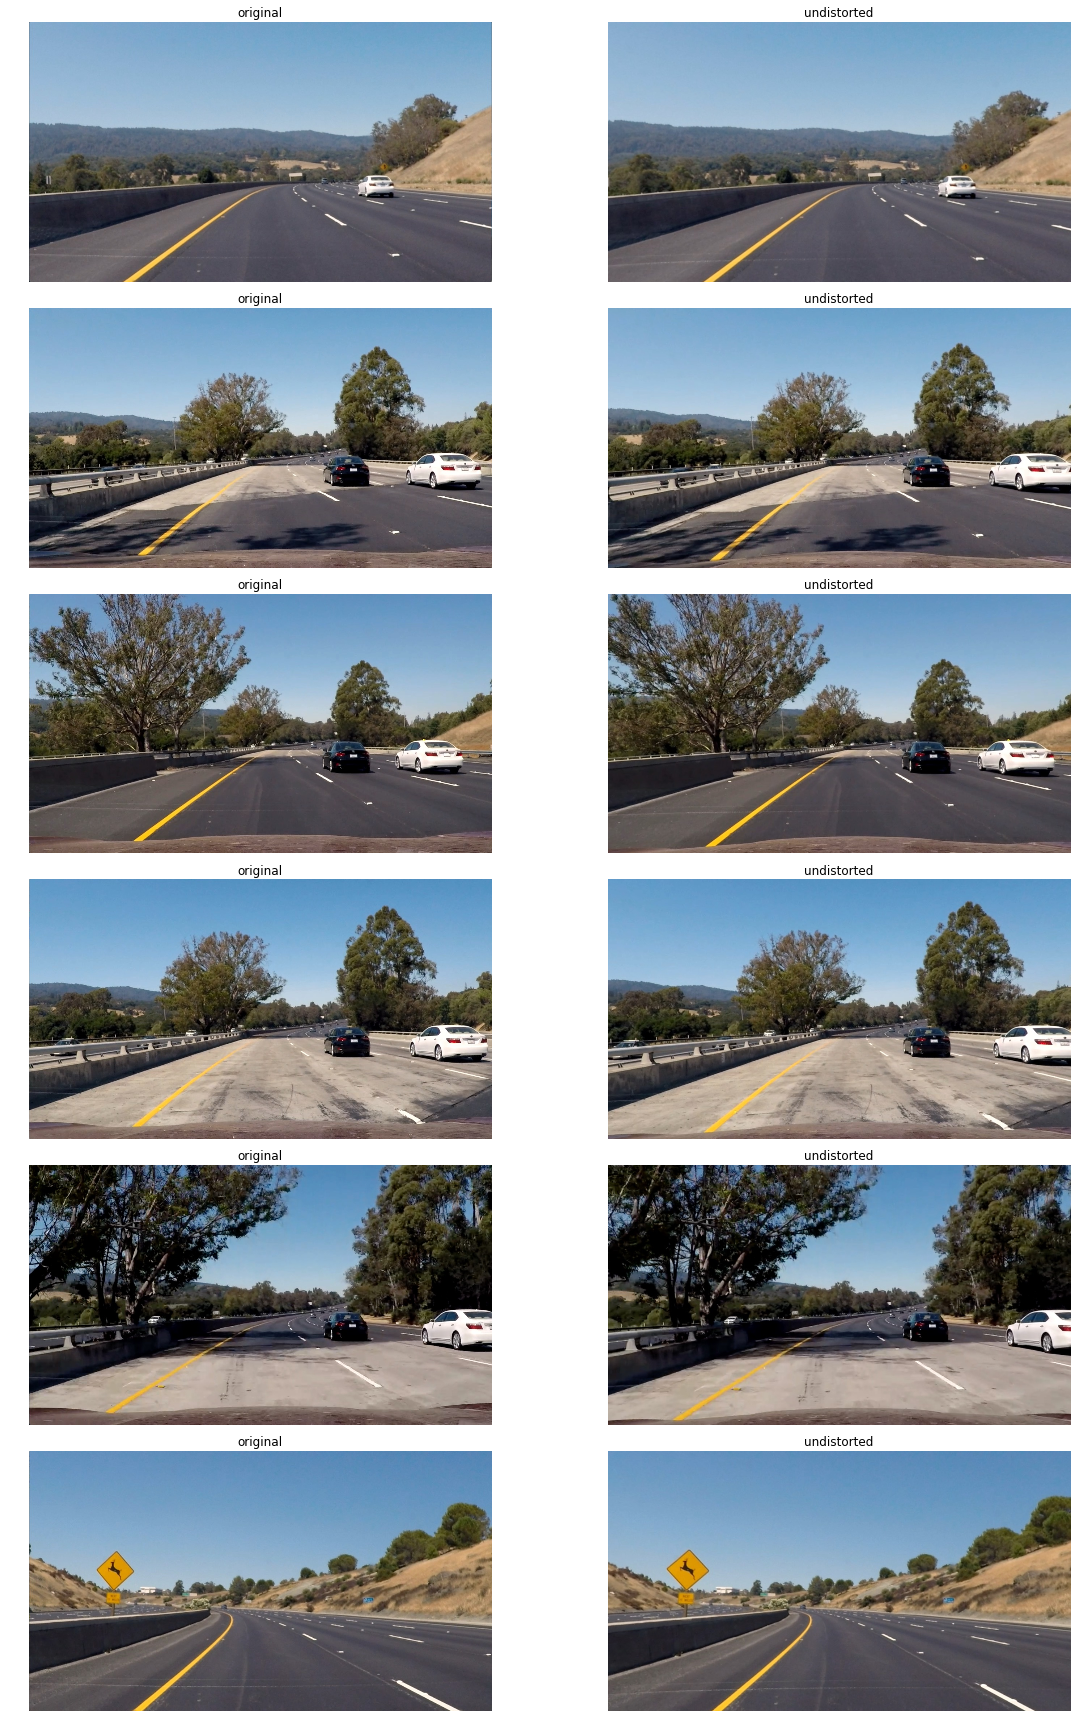

In [5]:
from glob import glob
chessboard_imgs = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) 
                   for f in glob("camera_cal/*.jpg")]
cc = CameraCalibrator()
cc.fit(chessboard_imgs)
cc.save("tmp/camera_calibrator.p")
cc.restore("tmp/camera_calibrator.p")


fig, axes = plt.subplots(6, 2, figsize = (8*2, 4*6))
fig.tight_layout()
fig.subplots_adjust(wspace = 0.1, hspace=0.1, )
for ax, test_img in zip(axes, test_imgs):
    ax[0].imshow(test_img)
    ax[0].set_title("original")
    ax[0].set_axis_off()
    undist = cc.undistort(test_img)
    ax[1].imshow(undist)
    ax[1].set_title("undistorted")
    ax[1].set_axis_off()

## Line Detection

In [101]:
class LineDetector(object):
    """Detect lines (e.g. lane boundaries) in images using a combination 
    of different methods. It supports different line detection 
    algorithms and their combinations. For now the user needs 
    to pre-configure the methods beforehand, it may support 
    automated algorithm selection based on images in the future.
    
    There are three main steps in configuring a line detector:
        - convert color images to gray, e.g, by RGB->gray or HLS->S
        - line detection, e.g., canny, sobel_x, sobel_y, sobel_magnitude, sobel_dir
        - filtering, e.g., by threshold of pixel, line oritentation, etc.
    A pipeline can be built by setting different choices at each setp.
    A combination can be done by using AND/OR operations on the resulted line(binary) images.
    The combination also has a smoothing effect like Gaussian filtering. Using a larger
    `ksize` has the same effect.
    """
    def __init__(self):
        pass
    def gray_converter(self, gray_type):
        """Create gray_image_converter for line detecion pipeline.
        `gray_type`: {"gray", "saturation", "hue"}.
        Returns a gray image converter function with RGB image input
            and a gray image output 
        """
        gray_type = gray_type.lower()
        def f(img):
            if gray_type == "gray":
                return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            elif gray_type == "saturation":
                return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:, :, 2]
            elif gray_type == "hue":
                return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:, :, 0]
            elif gray_type == "lightness":
                return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:, :, 1]
            else:
                raise ValueError("Unknown gray_type %s" % gray_type)
        return f
    def sobel_detector(self, sobel_type, ksize=3):
        """Create sobel based line dector for line detection pipeline.
        `sobel_type`: {"x", "y", "magnitude", "direction"}.
        `ksize`: kernel size for Sobel filter, default to 3
        Returns a function with gray image input and a Sobel image output, 
            the pixels of Sobel image is within [-$\pi$/2, $\pi$/2] for 'direction'
            and [0, 255] for other sobel_types
        """
        sobel_type = sobel_type.lower()
        def f(gray):
            sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
            sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
            if sobel_type == "x":
                sobel = np.absolute(sobelx)
            elif sobel_type == "y":
                sobel = np.absolute(sobely)
            elif sobel_type == "magnitude":
                sobel = np.sqrt(sobelx*sobelx + sobely*sobely)
            elif sobel_type == "direction":
                sobel = np.arctan(sobely / (sobelx + 1e-6))
            else:
                raise ValueError("Unknown sobel_type %s" % sobel_type)
            # normalize sobel as a normal gray image, so it can be visualized
            if sobel_type in ["x", "y", "magnitude"]:
                sobel = (sobel * 255. / sobel.max()).astype(np.uint8)
            return sobel
        return f
    def threshold_filter(self, lower, upper):
        """Create binary filter for line detection pipeline.
        `lower`, `upper` are bounds for pixel value (distributed between 0, 255).
        Returns a function that returns a binary image, where pixels in [lower, upper]
        are 1 and the rest are 0.
        """
        def f(gray):
            binary = (gray >= lower) & (gray <= upper)
            return binary
        return f
    def make_pipeline(self, steps):
        """Create a pipeline composed of each step
        """
        def compose2(f, g):
            return lambda x: g(f(x))
        return functools.reduce(compose2, steps)
    def AND(self, f, g):
        def _and(x):
            return f(x) & g(x)
        return _and
    def OR(self, f, g):
        def _or(x):
            return f(x) | g(x)
        return _or

### test line detector

In [102]:
ld = LineDetector()

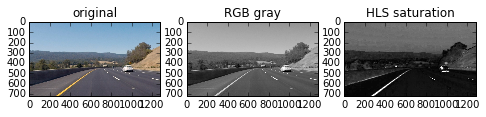

In [103]:
## test gray converter
rgb_gray_converter = ld.gray_converter("gray")
hls_gray_converter = ld.gray_converter("saturation")
test_img = test_imgs[0]
rgb_gray = rgb_gray_converter(test_img)
hls_gray = hls_gray_converter(test_img)
fig, axes = plt.subplots(1, 3, figsize=(8*1, 3*4))
axes[0].imshow(test_img)
axes[0].set_title("original")
axes[1].imshow(rgb_gray, cmap=plt.cm.gray)
axes[1].set_title("RGB gray")
axes[2].imshow(hls_gray, cmap=plt.cm.gray)
axes[2].set_title("HLS saturation")

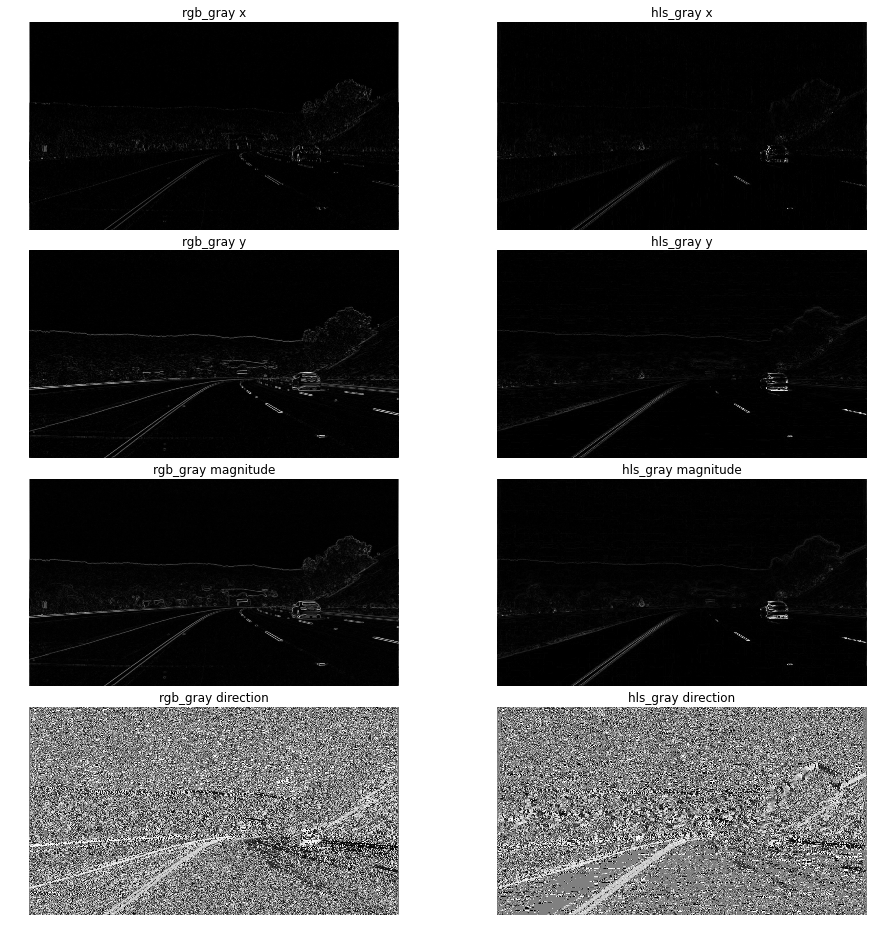

In [104]:
## test sobel filter
fig, axes = plt.subplots(4, 2, figsize=(2*8, 4 * 4))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
gray_imgs = [("rgb_gray", rgb_gray), ("hls_gray", hls_gray)]
sobels = [(s, ld.sobel_detector(s)) for s in ["x", "y", "magnitude", "direction"]]
for c, (gray_type, gray_img) in enumerate(gray_imgs):
    for r, (sobel_type, sobel_fn) in enumerate(sobels):
        sobel = sobel_fn(gray_img)
        axes[r,c].imshow(sobel, cmap=plt.cm.gray)
        axes[r,c].set_title("%s %s" % (gray_type, sobel_type))
        axes[r,c].set_axis_off()

In [105]:
## test make a pipe
fs = [lambda x, i=i: "%s -> f%d" % (x, i) for i in range(10)]
p = ld.make_pipeline(fs)
p("s")

's -> f0 -> f1 -> f2 -> f3 -> f4 -> f5 -> f6 -> f7 -> f8 -> f9'

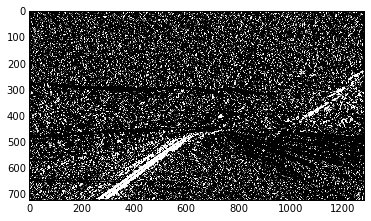

In [106]:
## test make a line detector by piping different steps

directional_line_detector = ld.make_pipeline([
    ld.gray_converter("gray")
    , ld.sobel_detector("direction", ksize=15)
    , ld.threshold_filter(0.7, 1.2)
#     , ld.threshold_filter(-1.2, 0.7)
])

directional_line_img = directional_line_detector(test_imgs[0])
plt.imshow(directional_line_img, cmap=plt.cm.gray)

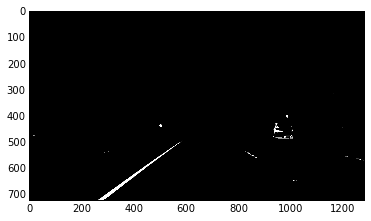

In [107]:

color_line_detector = ld.make_pipeline([
    ld.gray_converter("saturation")
    , ld.threshold_filter(175, 255)
])

color_line_img = color_line_detector(test_imgs[0])
plt.imshow(color_line_img, cmap=plt.cm.gray)

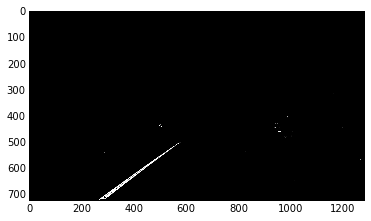

In [108]:
# combination
combined_line = directional_line_img&color_line_img
plt.imshow(combined_line, cmap=plt.cm.gray)

### observations
two steps
- make all lines that should be detected visible
- remove noise

some tricks
- color_detector is going to help a lot with reducing noise, e.g., trees that have dark colors

In [205]:
# test everything put together
ksize = 3
gradx_detector = ld.make_pipeline([
        ld.gray_converter("saturation")
#         ld.gray_converter("hls")
        , ld.sobel_detector("x", ksize=ksize)
        , ld.threshold_filter(25, 125)
])
grady_detector = ld.make_pipeline([
        ld.gray_converter("saturation")
#         ld.gray_converter("hls")
        , ld.sobel_detector("y", ksize=ksize)
        , ld.threshold_filter(20, 125)
])
mag_detector = ld.make_pipeline([
        ld.gray_converter("saturation")
#         ld.gray_converter("hls")
        , ld.sobel_detector("magnitude", ksize=ksize)
        , ld.threshold_filter(20, 125)
])
left_dir_detector = ld.make_pipeline([
        ld.gray_converter("saturation")
#         ld.gray_converter("hls")
        , ld.sobel_detector("direction", ksize=ksize)
        , ld.threshold_filter(0.3, 1.5)
        
])
right_dir_detector = ld.make_pipeline([
        ld.gray_converter("saturation")
#         ld.gray_converter("hls")
        , ld.sobel_detector("direction", ksize=ksize)
        , ld.threshold_filter(-1.5, -0.3)
        
])
saturation_detector = ld.make_pipeline([
        ld.gray_converter("saturation")
        , ld.threshold_filter(50, 255)
])

lightness_detector = ld.make_pipeline([
        ld.gray_converter("lightness")
        , ld.threshold_filter(100, 255)
])


# line_detector = ld.OR(
#                     #ld.AND(gradx_detector, grady_detector)
#                     gradx_detector
#                     , ld.AND(mag_detector, dir_detector))
# #line_detector = ld.AND(gradx_detector, color_detector)

line_detector = ld.AND( gradx_detector, ld.OR(left_dir_detector, right_dir_detector))
#line_detector = ld.OR(line_detector, ld.AND(grady_detector, ld.OR(left_dir_detector, right_dir_detector)))
# line_detector = ld.AND(line_detector, lightness_detector)
#line_detector = ld.AND(line_detector, saturation_detector)

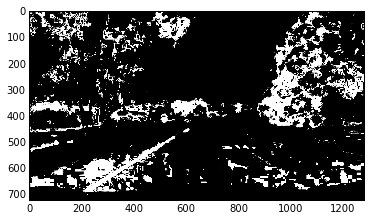

In [206]:
a = yellow_detector(test_imgs[-2])
# a = a[650:670, 250:270]
plt.imshow(a, cmap=plt.cm.gray)

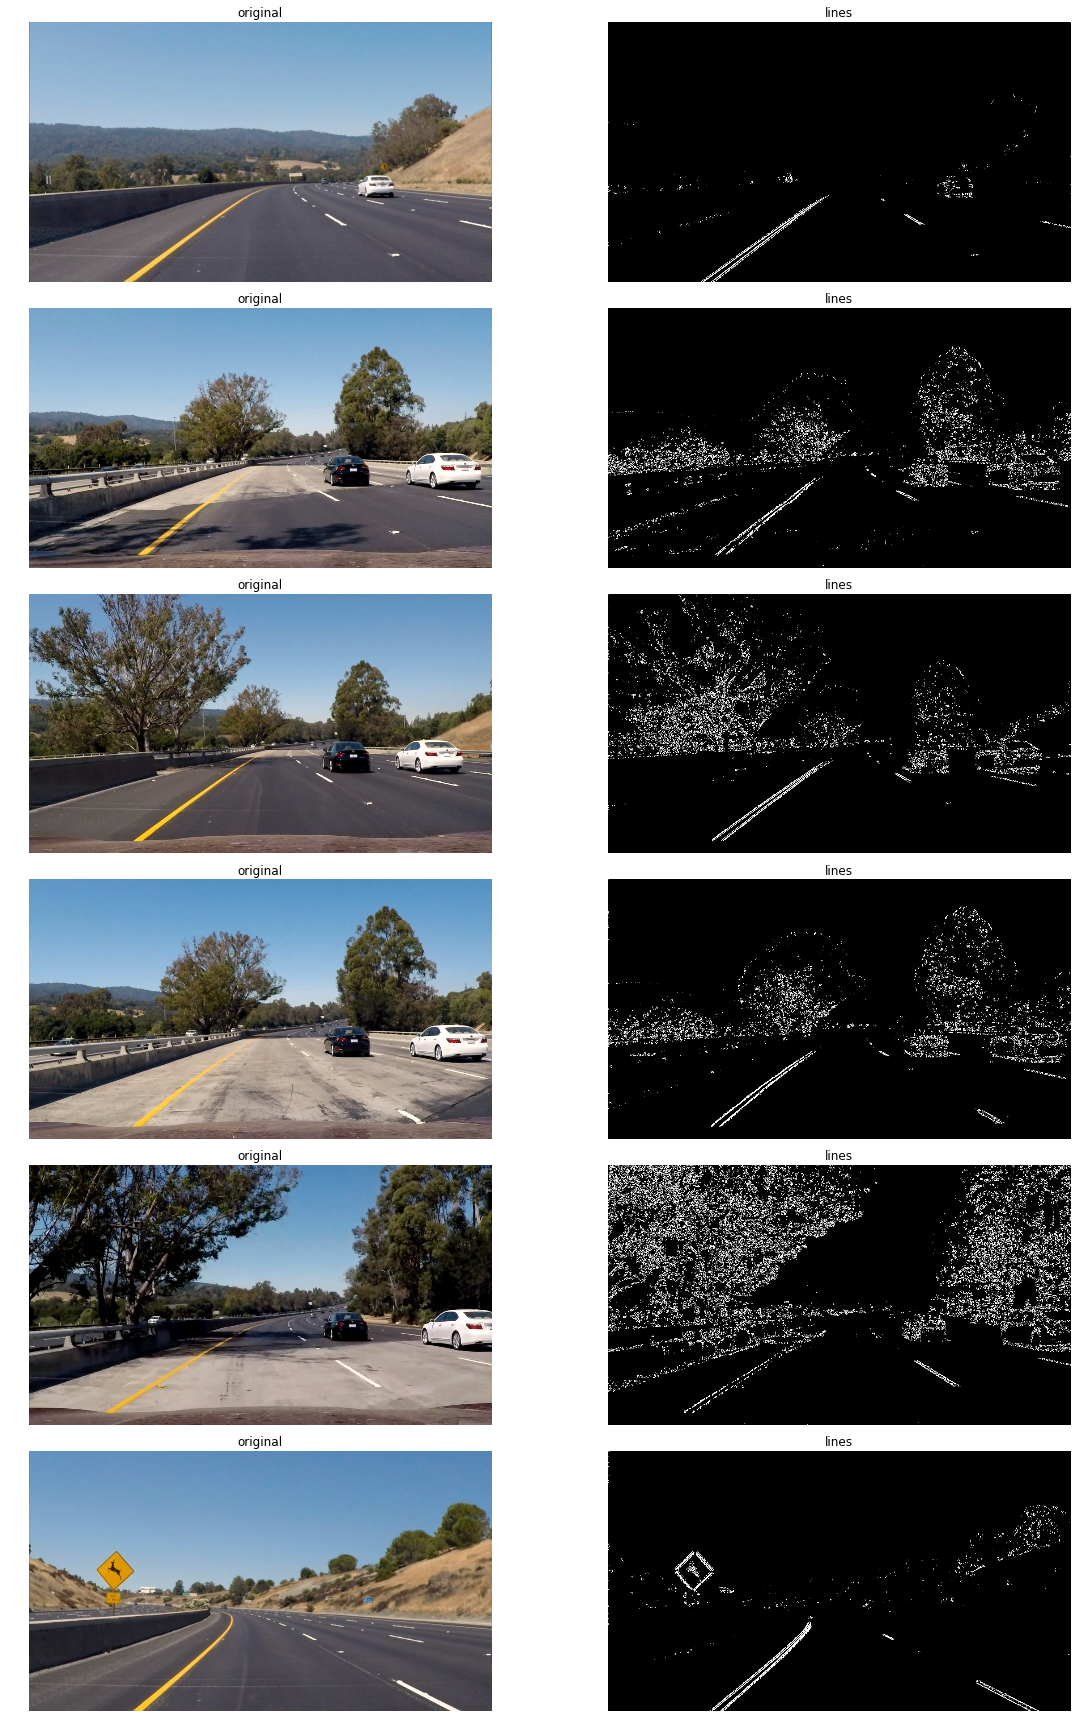

In [207]:
fig, axes = plt.subplots(6, 2, figsize = (8*2, 4*6))
fig.tight_layout()
fig.subplots_adjust(wspace = 0.1, hspace=0.1, )
for ax, test_img in zip(axes, test_imgs):
    ax[0].imshow(test_img)
    ax[0].set_title("original")
    ax[0].set_axis_off()
    lines = line_detector(test_img)
    ax[1].imshow(lines, cmap=plt.cm.gray)
    ax[1].set_title("lines")
    ax[1].set_axis_off()